# Projet Web Mining "Information Retrieval System" avec Word2Vec modèle

# ---------------------------------------------------------------------------------------------------------------

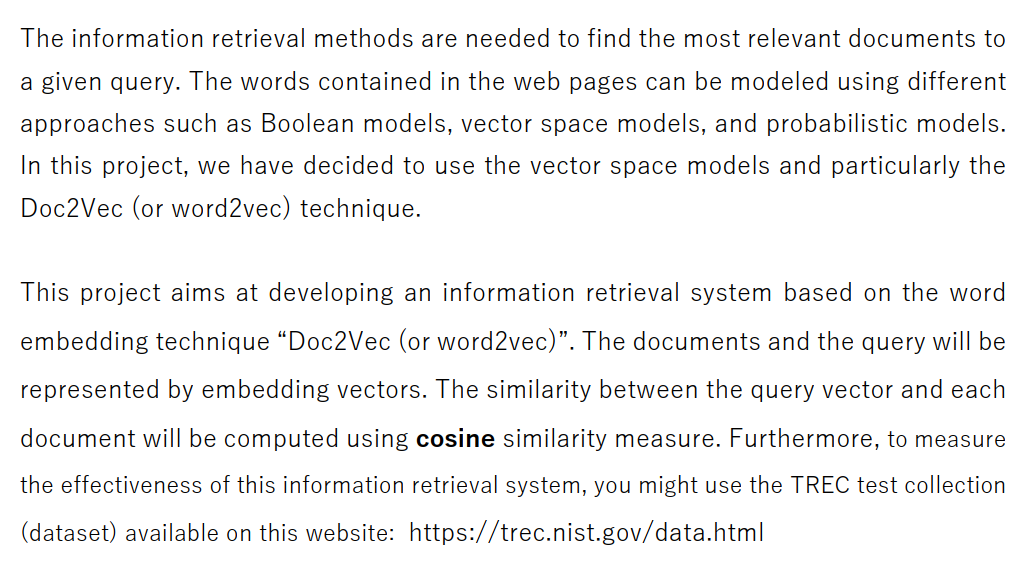

# Téléchargement des fichiers de Données

In [1]:
!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-docs.tsv.gz
!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-doctrain-queries.tsv.gz
!wget https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-doctrain-top100.gz
	
!gzip -d msmarco-docs.tsv.gz
!gzip -d msmarco-doctrain-queries.tsv.gz
!gzip -d msmarco-doctrain-top100.gz

--2021-02-02 14:16:53--  https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-docs.tsv.gz
Resolving msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)... 40.112.152.16
Connecting to msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)|40.112.152.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8446274598 (7.9G) [application/x-gzip]
Saving to: ‘msmarco-docs.tsv.gz’

msmarco-docs.tsv.gz 100%[===================>]   7.87G  3.42MB/s    in 34m 24s 

2021-02-02 14:51:17 (3.90 MB/s) - ‘msmarco-docs.tsv.gz’ saved [8446274598/8446274598]

--2021-02-02 14:51:17--  https://msmarco.blob.core.windows.net/msmarcoranking/msmarco-doctrain-queries.tsv.gz
Resolving msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)... 40.112.152.16
Connecting to msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)|40.112.152.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6457962 (6.2M) [application/x-gzip]
Saving to

# Importation et Installation des Bibliothèques python

In [3]:
!pip install 'fsspec>=0.3.3'

     |████████████████████████████████| 102kB 4.0MB/s 


In [4]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

## Chargement et Exploration du fichier "msmarco-doctrain-queries.tsv" qui contient les (queries)

In [5]:
queries=pd.read_table('msmarco-doctrain-queries.tsv',header=None)

print('la taille du fichier :',queries.shape)
#queries.head()

la taille du fichier : (367013, 2)


# Réduction des dimensions du fichier à 1000 ligne et 2 colonnes

In [6]:
queries.columns=['qid','query']

queries=queries.sample(n=1000,random_state=42).reset_index(drop=True)
print('la taille du fichier après reduction:',queries.shape)
#queries.head()

la taille du fichier après reduction: (1000, 2)


# Pour entrainer notre propre Wrd2vec modele en va déviser nos fichiers en training partie et testing partie avec la moitie des données pour chaque partie 

# Création de la partie training a partir du tableau queries

In [28]:
queries_train=queries.iloc[:500]
print('taille des données d entrainement :',queries_train.shape)
queries_train.head()

taille des données d entrainement : (500, 2)


,qid,query
0,687888,what is a jpe
1,480210,price for asphalt driveway
2,591004,what causes pressure skin bruising
3,260536,how long drive from flagstaff to grand canyon
4,39422,average number of bowel movements per day for ...


# Création de la partie testing a partir du tableau queries

In [29]:
queries_test=queries.iloc[500:]
print('taille des données de test :',queries_test.shape)
queries_test.head()

taille des données de test : (500, 2)


,qid,query
500,116364,decree verb definition
501,638813,what does hemiballistic mean
502,401631,is advil considered aspirin?
503,1050265,who sang the song midnight train to georgia
504,632336,what does aq mean in chemistry


# Maintenant on va continuer la reduction des autres fichiers en prenant compte de la réduction précédente ****

# Chargement et réduction du fichier "msmarco-doctrain-top100.gz" qui contient les top 100 documents pour chaque querie dans les données d'entrainement et test

In [9]:
docs_top_100=pd.read_table('/content/msmarco-doctrain-top100',delimiter=' ',header=None)
docs_top_100.columns=['qid','Q0','docid','rank','score','runstring']
print('taille de tableau des documents :',docs_top_100.shape)

taille de tableau des documents : (36701116, 6)


In [10]:
docs_top_100.head()

,qid,Q0,docid,rank,score,runstring
0,1185869,Q0,D59221,1,-4.80433,IndriQueryLikelihood
1,1185869,Q0,D59220,2,-4.92127,IndriQueryLikelihood
2,1185869,Q0,D2192591,3,-5.05215,IndriQueryLikelihood
3,1185869,Q0,D2777518,4,-5.05486,IndriQueryLikelihood
4,1185869,Q0,D2371978,5,-5.07048,IndriQueryLikelihood


# Réduction des documents pour la partie train

In [11]:
train_ranked_docs=docs_top_100[docs_top_100['qid'].isin(queries_train['qid'].unique())].reset_index(drop=True)
print('taille de tableau des documents pour training',train_ranked_docs.shape)
train_ranked_docs.head()

taille de tableau des documents pour training (50000, 6)


,qid,Q0,docid,rank,score,runstring
0,310290,Q0,D579750,1,-5.11498,IndriQueryLikelihood
1,310290,Q0,D579754,2,-5.57703,IndriQueryLikelihood
2,310290,Q0,D2380815,3,-5.84852,IndriQueryLikelihood
3,310290,Q0,D822566,4,-5.95002,IndriQueryLikelihood
4,310290,Q0,D2249695,5,-6.08326,IndriQueryLikelihood


# Réduction des documents pour la partie test

In [12]:
test_ranked_docs=docs_top_100[docs_top_100['qid'].isin(queries_test['qid'].unique())].reset_index(drop=True)
print('taille de tableau des documents pour testing',test_ranked_docs.shape)
test_ranked_docs.head()

taille de tableau des documents pour testing (50000, 6)


,qid,Q0,docid,rank,score,runstring
0,666453,Q0,D583079,1,-4.40672,IndriQueryLikelihood
1,666453,Q0,D846798,2,-4.63949,IndriQueryLikelihood
2,666453,Q0,D84078,3,-4.65195,IndriQueryLikelihood
3,666453,Q0,D2930759,4,-4.71332,IndriQueryLikelihood
4,666453,Q0,D3209901,5,-4.71444,IndriQueryLikelihood


# Réduction des 100 documents à 10 (les 5 premiers "relevent" et les derniers "not relevent") pour ne pas avoir des problèmes au niveau de la RAM et du temps d'execution

In [13]:
relevent=list(range(1,6))
nonrelevent=list(range(95,100))

train_ranked_docs['relevance']=train_ranked_docs['rank'].apply(lambda x: 1 if x in relevent else ( 0 if x in nonrelevent else np.nan))
test_ranked_docs['relevance']=test_ranked_docs['rank'].apply(lambda x: 1 if x in relevent else ( 0 if x in nonrelevent else np.nan))

# Données d'entrainement pour "train_ranked_docs" après réduction

In [14]:
train_ranked_docs_r=train_ranked_docs.dropna()
train_ranked_docs_r['relevance']=train_ranked_docs_r['relevance'].astype(int)

print('taille de tableau des documents pertinents et non pertinents pour training :',train_ranked_docs_r.shape)
train_ranked_docs_r.head(10)

taille de tableau des documents pertinents et non pertinents pour training : (5000, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,qid,Q0,docid,rank,score,runstring,relevance
0,310290,Q0,D579750,1,-5.11498,IndriQueryLikelihood,1
1,310290,Q0,D579754,2,-5.57703,IndriQueryLikelihood,1
2,310290,Q0,D2380815,3,-5.84852,IndriQueryLikelihood,1
3,310290,Q0,D822566,4,-5.95002,IndriQueryLikelihood,1
4,310290,Q0,D2249695,5,-6.08326,IndriQueryLikelihood,1
94,310290,Q0,D241849,95,-6.38067,IndriQueryLikelihood,0
95,310290,Q0,D1595214,96,-6.38076,IndriQueryLikelihood,0
96,310290,Q0,D776635,97,-6.38219,IndriQueryLikelihood,0
97,310290,Q0,D1610603,98,-6.38342,IndriQueryLikelihood,0
98,310290,Q0,D2882647,99,-6.38541,IndriQueryLikelihood,0


# Données d'entrainement pour "train_ranked_docs" après réduction

In [16]:
test_ranked_docs_r=test_ranked_docs.dropna()
test_ranked_docs_r['relevance']=test_ranked_docs_r['relevance'].astype(int)

print('taille de tableau des documents pertinents et non pertinents pour testing :',test_ranked_docs_r.shape)
test_ranked_docs_r.head(10)

taille de tableau des documents pertinents et non pertinents pour testing : (5000, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,qid,Q0,docid,rank,score,runstring,relevance
0,666453,Q0,D583079,1,-4.40672,IndriQueryLikelihood,1
1,666453,Q0,D846798,2,-4.63949,IndriQueryLikelihood,1
2,666453,Q0,D84078,3,-4.65195,IndriQueryLikelihood,1
3,666453,Q0,D2930759,4,-4.71332,IndriQueryLikelihood,1
4,666453,Q0,D3209901,5,-4.71444,IndriQueryLikelihood,1
94,666453,Q0,D2078583,95,-5.01411,IndriQueryLikelihood,0
95,666453,Q0,D3165498,96,-5.01606,IndriQueryLikelihood,0
96,666453,Q0,D3185115,97,-5.01941,IndriQueryLikelihood,0
97,666453,Q0,D1534785,98,-5.02105,IndriQueryLikelihood,0
98,666453,Q0,D2591296,99,-5.02105,IndriQueryLikelihood,0


# Maintenant on va réduire le fichier "msmarco-docs.tsv.gz" qui contient les documents

In [17]:
docs=dd.read_table('msmarco-docs.tsv',blocksize=100e6,header=None)
docs.columns=['docid','url','title','body']
docs.head()

,docid,url,title,body
0,D1555982,https://answers.yahoo.com/question/index?qid=2...,The hot glowing surfaces of stars emit energy ...,Science & Mathematics Physics The hot glowing ...
1,D301595,http://childparenting.about.com/od/physicalemo...,Developmental Milestones and Your 8-Year-Old C...,School-Age Kids Growth & Development Developme...
2,D1359209,http://visihow.com/Check_for_Lice_Nits,Check for Lice Nits,Check for Lice Nits Edited by Mian Sheilette O...
3,D2147834,http://www.nytimes.com/2010/01/05/business/glo...,Dubai Opens a Tower to Beat All,Global Business Dubai Opens a Tower to Beat Al...
4,D1568809,http://www.realtor.com/realestateandhomes-sear...,"Coulterville, CA Real Estate & Homes for Sale","Coulterville, CA Real Estate & Homes for Sale4..."


# cette méthode va prendre seulement les documents dont les id_doc existent dans la partie train et test

In [18]:
def docs_reducing(data):
  
  unique_docid=data['docid'].unique()
  cond=docs['docid'].isin(unique_docid)
  corpus_docs=docs[cond].reset_index(drop=True)
  corpus_docs=corpus_docs.drop(columns='url')
  
  return corpus_docs

# Réduction pour le training

In [19]:
training_docs=docs_reducing(train_ranked_docs_r)
training_docs.head()

,docid,title,body
0,D71084,"Tatum, Texas",Follow city-data.com founder on our Forum or@L...
1,D3190098,.,Tomato Disease Identification Use the followin...
2,D563791,Packers vs. Patriots: Previewing New England's...,New England Patriots Packers vs. Patriots: Pre...
3,D647705,"""Car Accident Cause And Effect"" Essays and Res...","""Car Accident Cause And Effect"" Essays and Res..."
4,D2577935,"The Good, Bad and Interesting Roles of Nitroge...","The Good, Bad and Interesting Roles of Nitroge..."


# Réduction pour le testing

In [20]:
testing_docs=docs_reducing(test_ranked_docs_r)
testing_docs.head()

,docid,title,body
0,D1881859,Franking Privilege Law and Legal Definition,Franking Privilege Law and Legal Definition Fr...
1,D941093,.,Cold weather can leave liriope (commonly calle...
2,D1369420,What constitutes a scientific name?,Answers.com ® Wiki Answers ® Categories Relati...
3,D1259464,Salzburg Monthly Climate Averages,"Salzburg Monthly Climate Averages Salzburg, Au..."
4,D151235,What are the best affordable headphones/earpho...,"Shivanshu Verma, Music lover and keep testing ..."


# En ce moment on va passer au traitement de ces documents et requetes ""Text Preprocessing""

# Premierement on va traiter les documents**

In [21]:
import re

# rendre les textes en format Minuscule 

training_docs['cleaned']=training_docs['body'].apply(lambda x:x.lower())
testing_docs['cleaned']=testing_docs['body'].apply(lambda x:x.lower())

# Dictionnaire des contractions en englais

contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not","can't": "can not","can't've": "cannot have",
"'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have",
"didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will",
"he'll've": "he will have","how'd": "how did","how'd'y": "how do you","how'll": "how will","i'd": "i would",
"i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have",
"isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have",
"let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
"oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
"shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will",
"she'll've": "she will have","should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","so've": "so have","that'd": "that would","that'd've": "that would have",
"there'd": "there would","there'd've": "there would have",
"they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have",
"they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would",
"we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
"weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are",
"what've": "what have","when've": "when have","where'd": "where did",
"where've": "where have","who'll": "who will","who'll've": "who will have","who've": "who have",
"why've": "why have","will've": "will have","won't": "will not","won't've": "will not have",
"would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all",
"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would","you'd've": "you would have","you'll": "you will","you'll've": "you will have",
"you're": "you are","you've": "you have"}

# Une expression réguliere pour trouver les contractions en anglais
contractions_RE=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Régler le problème des contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_RE.sub(replace, text)


# Application sur notres documents

training_docs['cleaned']=training_docs['cleaned'].apply(lambda x:expand_contractions(x))
testing_docs['cleaned']=testing_docs['cleaned'].apply(lambda x:expand_contractions(x))

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:3073: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('body', 'object'))

  warnings.warn(meta_warning(meta))
/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:3073: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('cleaned', 'object'))

  warnings.warn(meta_

## Fonction pour netoyer le texte

In [22]:
def cleaning_text(text):
    text=re.sub('\w*\d\w*','', text)
    text=re.sub('\n',' ',text)
    text=re.sub(r"http\S+", "", text)
    text=re.sub('[^a-z]',' ',text)
    return text
 
# netoyer le texte dans les documents
training_docs['cleaned']=training_docs['cleaned'].apply(lambda x: cleaning_text(x))
testing_docs['cleaned']=testing_docs['cleaned'].apply(lambda x: cleaning_text(x))

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:3073: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('cleaned', 'object'))

  warnings.warn(meta_warning(meta))


# Suppression des espaces supplémentaires dans les textes

In [23]:
training_docs['cleaned']=training_docs['cleaned'].apply(lambda x: re.sub(' +',' ',x))
testing_docs['cleaned']=testing_docs['cleaned'].apply(lambda x: re.sub(' +',' ',x))

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:3073: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('cleaned', 'object'))

  warnings.warn(meta_warning(meta))


In [24]:
testing_docs['cleaned'].head()

0    franking privilege law and legal definition fr...
1    cold weather can leave liriope commonly called...
2    answers com wiki answers categories relationsh...
3    salzburg monthly climate averages salzburg aus...
4    shivanshu verma music lover and keep testing m...
Name: cleaned, dtype: object

In [25]:
training_docs['cleaned'].head()

0    follow city data com founder on our forum or l...
1    tomato disease identification use the followin...
2    new england patriots packers vs patriots previ...
3     car accident cause and effect essays and rese...
4    the good bad and interesting roles of nitrogen...
Name: cleaned, dtype: object

# Supression des stopwords

In [27]:
import spacy
nlp = spacy.load('en_core_web_sm',disable=['ner','parser'])
nlp.max_length=5000000

# suppression des stopwords et lemmatization des mots

training_docs['lemmatized']=training_docs['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
testing_docs['lemmatized']=testing_docs['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:3073: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('cleaned', 'object'))

  warnings.warn(meta_warning(meta))


# Traitements des queries

In [30]:
# Rendre les lettres minuscule
queries_train['cleaned']=queries_train['query'].apply(lambda x:x.lower())
queries_test['cleaned']=queries_test['query'].apply(lambda x:x.lower())

# Expanding contractions
queries_train['cleaned']=queries_train['cleaned'].apply(lambda x:expand_contractions(x))
queries_test['cleaned']=queries_test['cleaned'].apply(lambda x:expand_contractions(x))

# netoyage des requetes avec les expressions regulieres
queries_train['cleaned']=queries_train['cleaned'].apply(lambda x: cleaning_text(x))
queries_test['cleaned']=queries_test['cleaned'].apply(lambda x: cleaning_text(x))

# suppression des espaces 
queries_train['cleaned']=queries_train['cleaned'].apply(lambda x: re.sub(' +',' ',x))
queries_test['cleaned']=queries_test['cleaned'].apply(lambda x: re.sub(' +',' ',x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Combiner les requêtes et leurs documents associés pour l'entrainement

In [31]:
d_q_combined_training=dd.concat([training_docs.rename(columns={'lemmatized':'text'})['text'],\
                             queries_train.rename(columns={'cleaned':'text'})['text']])\
                             .sample(frac=1).reset_index(drop=True)

In [32]:
d_q_combined_training.head()

0    doctor insight aleve blood thin share follow h...
1    lisa fischer faqs fact rumor birthdate net wor...
2    good bad interesting role nitrogen n nitrogen ...
3      contribution long dog carry puppy dog usuall...
4    new england patriot packers vs patriot preview...
Name: text, dtype: object

# Le modèle Word2Vec

In [33]:
from gensim.models import Word2Vec

# création des données pour le word2vec
data_for_training=[]
for c in d_q_combined_training: 
    data_for_training.append(c.split())

# notre modèle
w2v_model = Word2Vec(data_for_training, size=300, min_count=2,window=5, sg=1,workers=4)

# la fonction qui retourne les vecteurs representatives des documents

In [34]:
def get_embedding_w2v(doc_tokens):
    embeddings = []
    if len(doc_tokens)<1:
        return np.zeros(300)
    else:
        for tok in doc_tokens:
            if tok in w2v_model.wv.vocab:
                embeddings.append(w2v_model.wv.word_vec(tok))
            else:
                embeddings.append(np.random.rand(300))
        # mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)

# Avoir les Word2Vec vecteurs pour le corpus de test et les requetes
testing_docs['vector']=testing_docs['lemmatized'].apply(lambda x :get_embedding_w2v(x.split()))
queries_test['vector']=queries_test['cleaned'].apply(lambda x :get_embedding_w2v(x.split()))

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:3073: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lemmatized', 'object'))

  warnings.warn(meta_warning(meta))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
testing_docs.head()

,docid,title,body,cleaned,lemmatized,vector
0,D1881859,Franking Privilege Law and Legal Definition,Franking Privilege Law and Legal Definition Fr...,franking privilege law and legal definition fr...,frank privilege law legal definition franking ...,"[0.08367727088478423, 0.09564569823345723, 0.0..."
1,D941093,.,Cold weather can leave liriope (commonly calle...,cold weather can leave liriope commonly called...,cold weather leave liriope commonly call monke...,"[0.06911505352799235, 0.043802375559268136, 0...."
2,D1369420,What constitutes a scientific name?,Answers.com ® Wiki Answers ® Categories Relati...,answers com wiki answers categories relationsh...,answer com wiki answer category relationship c...,"[0.05554529362373615, 0.09825149308597492, 0.1..."
3,D1259464,Salzburg Monthly Climate Averages,"Salzburg Monthly Climate Averages Salzburg, Au...",salzburg monthly climate averages salzburg aus...,salzburg monthly climate average salzburg aust...,"[0.1031385584929052, -0.02491604748204963, 0.0..."
4,D151235,What are the best affordable headphones/earpho...,"Shivanshu Verma, Music lover and keep testing ...",shivanshu verma music lover and keep testing m...,shivanshu verma music lover test music system ...,"[0.032083885111155404, -0.0379049432080141, 0...."


# Transformation des données en format pandas

In [41]:
testing_docs = testing_docs.compute()

# Fonction qui calcule la avg precision

In [42]:
from sklearn.metrics.pairwise import cosine_similarity


def AVG_Precision(qid,qvector):
  
  # Getting the ground truth and document vectors
  qresult=test_ranked_docs_r.loc[test_ranked_docs_r['qid']==qid,['docid','relevance']]
  qcorpus=testing_docs.loc[testing_docs['docid'].isin(qresult['docid']),['docid','vector']]
  #qcorpus = qcorpus.compute()
  qresult=pd.merge(qresult,qcorpus,on='docid')
  
  # Ranking documents for the query
  qresult['similarity']=qresult['vector'].apply(lambda x: cosine_similarity(np.array(qvector).reshape(1, -1),np.array(x).reshape(1, -1)).item())
  qresult.sort_values(by='similarity',ascending=False,inplace=True)

  # prendre les 5 top élements pour l'evaluation 
  ranking=qresult.head(10)['relevance'].values
  
  # Calcule de la precision 
  precision=[]
  for i in range(1,11):
    if ranking[i-1]:
      precision.append(np.sum(ranking[:i])/i)
  
  # si le document et non relevent retourner zero
  if precision==[]:
    return 0

  return np.mean(precision)

# Calcule de l'AVG Precision pour toutes les requetes des données de test
queries_test['Avg_Precision']=queries_test.apply(lambda x: AVG_Precision(x['qid'],x['vector']),axis=1)

# La moyenne de l'AVG Precision
print('Mean Average Precision ;',queries_test['Avg_Precision'].mean())

Mean Average Precision ; 0.7567485714285702


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Notre " Information retrieval System "

In [43]:
def IR_System(query):
  
  # pre-process Query
  query=query.lower()
  query=expand_contractions(query)
  query=cleaning_text(query)
  query=re.sub(' +',' ',query)

  # generating vector
  vector=get_embedding_w2v(query.split())

  # ranking documents
  documents=testing_docs[['docid','title','body']].copy()
  documents['similarity']=testing_docs['vector'].apply(lambda x: cosine_similarity(np.array(vector).reshape(1, -1),np.array(x).reshape(1, -1)).item())
  documents.sort_values(by='similarity',ascending=False,inplace=True)
  
  return documents.head(10).reset_index(drop=True)

# Tester le Systeme "IR_System"

In [45]:
IR_System("world")

,docid,title,body,similarity
0,D2895166,How Many Continents Are There in the World,How Many Continents Are There in the World Pos...,0.607197
1,D2253382,Largest US States,Largest US Statesview as: list / map▲ State Ar...,0.549929
2,D2244396,Midnight Train to Georgia Lyrics,l.a. proved too much for the man (too much for...,0.546856
3,D552734,Top 10 Most Popular Sports in The World 2017/18,Top 10 Most Popular Sports in The World 2017/1...,0.544830
4,D1603158,When did Italy join the European Union?,Answers.com ® Wiki Answers ® Categories Travel...,0.523452
5,D1603157,Why did Italy join the european union?,Answers.com ® Wiki Answers ® Categories Travel...,0.521332
6,D3258432,Top 10 Most Populated Cities in Europe,Top 10 Most Populated Cities in Europe Many ci...,0.519140
7,D3199345,Top Universities in the US by State 2014/15,**Click here to read about the top universitie...,0.516674
8,D2057672,Geography Challenge Level 1,150 terms reddirtcrew Geography Challenge Leve...,0.515797
9,D1460083,Sri Lanka,Print this map Print this map In the emerald-g...,0.515679


In [46]:
IR_System("basketBall")

,docid,title,body,similarity
0,D2785629,What is the name of a basketball team that is ...,Answers.com ® Wiki Answers ® Categories Entert...,0.690045
1,D1900195,What year did Michael Jordan play baseball?,Answers.com ® Wiki Answers ® Categories Entert...,0.661996
2,D1944506,How many years total did Michael Jordan play i...,How many years total did Michael Jordan play i...,0.647159
3,D657921,Kentucky Wildcats,"Kentucky Wildcats From Wikipedia, the free enc...",0.644775
4,D552734,Top 10 Most Popular Sports in The World 2017/18,Top 10 Most Popular Sports in The World 2017/1...,0.636907
5,D36035,Which Coach has the Highest Winning Percentage?,Answers.com ® Wiki Answers ® Categories Sports...,0.636721
6,D631057,.,Solutions Carlene Level 1 (Contributor)16 Answ...,0.633254
7,D2915659,Shawn Green,Shawn Green is a Jewish American former profes...,0.615147
8,D1091524,How long is the shot clock for college players?,"Dlmick 265,765 Contributions How long is the s...",0.614600
9,D1316035,Joe Mauer,"From Wikipedia, the free encyclopedianavigatio...",0.602298


In [47]:
IR_System("morocco")

,docid,title,body,similarity
0,D1039770,Official Listing of Countries by World Region,Humanities ›Geography Official Listing of Coun...,0.836750
1,D740502,What continent is Morocco on?,What continent is Morocco on? Morocco is on th...,0.799448
2,D3210554,What continent can you find the alps on?,What continent can you find the alps on? Europ...,0.771836
3,D2765489,How far is the UK from Sri Lanka?,"Gaines Fox 66,293 Contributions How far is the...",0.766617
4,D1460083,Sri Lanka,Print this map Print this map In the emerald-g...,0.751394
5,D2182009,Geographical dimensions: size and shape,Geographical dimensions: size and shape Unit H...,0.726515
6,D1878784,___ Puerto Rico,Got it!This website uses cookies to ensure you...,0.723039
7,D1333898,Geography of Sri Lanka,Humanities ›Geography Geography of Sri Lanka L...,0.721094
8,D2057672,Geography Challenge Level 1,150 terms reddirtcrew Geography Challenge Leve...,0.718680
9,D177024,What continent is Jamaica in?,Answers.com ® Wiki Answers ® Categories Travel...,0.716148
